# Exploratory analysis of ecosystem sensitivity

Plotting NDVI (including z-transformed) against USHCN climate and SPEI.

TO DO - need to examine zNDVI vs standardized precip (z-scored or SPI) and compare to zNDVI SPEI, maybe generate a pseudo r2 for the two relationships and compare.

In [1]:
library('ggplot2')
library('repr')
library('dplyr')

source('common_stats_functions.r')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: sp
rgdal: version: 1.4-7, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.3, released 2019/10/28
 Path to GDAL shared files: /usr/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 6.2.1, November 1st, 2019, [PJ_VERSION: 620]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


OGR data source with driver: ESRI Shapefile 
Source: "/home/greg/data/GD_gregmaurer/droughtnet_precipsens_data/NEONdomains", layer: "NEON_Domains"
with 22 features
It has 6 fields


Regions defined for each Polygons


In [2]:
df <- sensitivity_stats_df()

[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/MODIS/annual_ushcn_NDVI.csv"


Parsed with column specification:
cols(
  stationid = col_character(),
  year = col_double(),
  ndvi_mean = col_double(),
  ndvi_max = col_double(),
  ndvi_min = col_double(),
  ndvi_sum = col_double(),
  zndvi_mean = col_double(),
  zndvi_max = col_double(),
  zndvi_min = col_double(),
  zndvi_sum = col_double(),
  ndvi_gsmean = col_double(),
  ndvi_gssum = col_double(),
  zndvi_gsmean = col_double(),
  zndvi_gssum = col_double()
)


[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/USHCN_derived/annual_ushcn_spei_allstations.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character()
)
See spec(...) for full column specifications.


[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/USHCN_derived/allyr_ushcn_calcs_allstations.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character(),
  elev = col_character(),
  state = col_character(),
  name = col_character(),
  flag1 = col_character(),
  flag2 = col_character(),
  flag3 = col_character()
)
See spec(...) for full column specifications.


[1] "Assigning NEON domain names to locCalcs dataframe..."
OGR data source with driver: ESRI Shapefile 
Source: "/home/greg/data/GD_gregmaurer/droughtnet_precipsens_data/NEONdomains", layer: "NEON_Domains"
with 22 features
It has 6 fields
[1] "Loading ~/GD_gregmaurer/droughtnet_precipsens_data/MODIS/annual_ushcn_eeMODIS.csv"


Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character(),
  date = col_datetime(format = "")
)
See spec(...) for full column specifications.


[1] "Subsetting SPEI (>1999) and merging three dataframes..."
[1] "Removing 160 rows missing domain names..."


In [3]:
# Calculate mean annual precip by domain (2000-2015), then 
# us it to reorder the levels in df$neonDomainName for plotting
dom_map <- df %>% group_by(neonDomainName) %>% summarise(domain_map=mean(prcp_sum))

df <- left_join(df, dom_map, by='neonDomainName')
#df.t <- transform(df, neonDomainName=reorder(neonDomainName, domain_map))

# Get the order and reorder the neonDomainName factor levels
maporder <- order(dom_map$domain_map)
df$neonDomainName <- factor(df$neonDomainName,
                            levels=levels(df$neonDomainName)[maporder])
levels(df$neonDomainName)

[1] "Desert Southwest"                    "Great Basin"                        
 [3] "Southern Rockies / Colorado Plateau" "Northern Rockies"                   
 [5] "Northern Plains"                     "Central Plains"                     
 [7] "Pacific Southwest"                   "Southern Plains"                    
 [9] "Great Lakes"                         "Prairie Peninsula"                  
[11] "Northeast"                           "Mid Atlantic"                       
[13] "Appalachians / Cumberland Plateau"   "Pacific Northwest"                  
[15] "Ozarks Complex"                      "Southeast"                          
[17] "Atlantic Neotropical"

In [4]:
#Rename domains for plotting
df <- rename_domains_for_plotting(df)

In [5]:
# Set options for plotting
options(repr.plot.width=8.5, repr.plot.height=5)

## Examine precipitation sensitivity
### Annual summed NDVI vs precip

In [6]:
library('RColorBrewer')
cols <- colorRampPalette(brewer.pal(11,"Spectral"))
myPal <- cols(17)

### Exponential model describing spatial relationship of NPP vs Precip


Formula: ndvi_sum ~ C * (1 - exp(k * prcp_sum))

Parameters:
    Estimate Std. Error t value Pr(>|t|)    
C  8.100e+00  2.517e-02   321.8   <2e-16 ***
k -1.901e-03  1.537e-05  -123.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.095 on 18590 degrees of freedom

Algorithm "port", convergence message: relative convergence (4)
  (736 observations deleted due to missingness)


[1] 736

[1] 1.095007

[1] 0.1874998

[1] 0.1166505

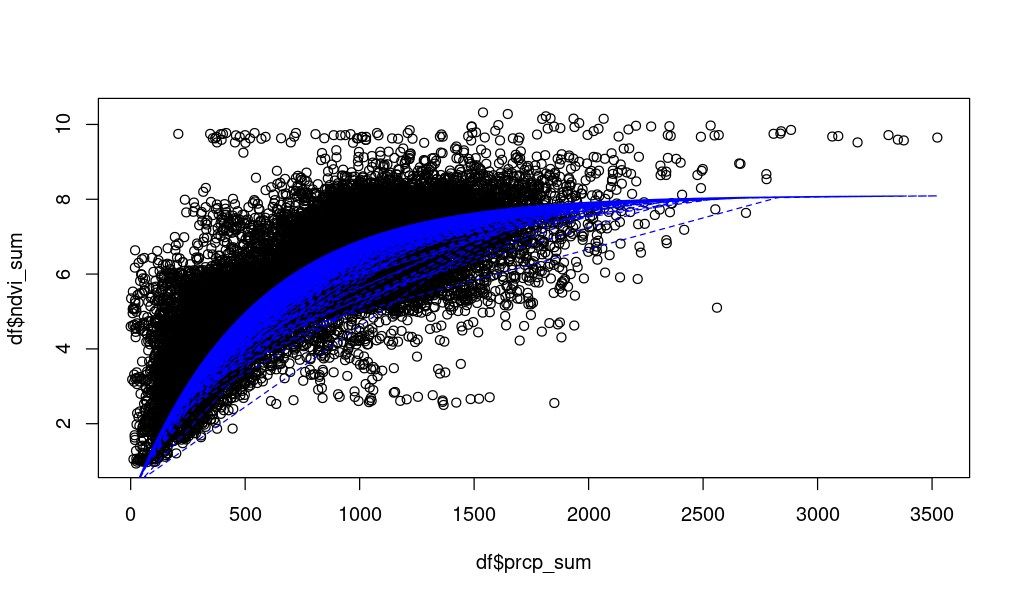

In [7]:
# Fit an exponential model to the ALL data that can be plotted 
set.seed(1)     # so the example is reproduceable
fit <- nls(ndvi_sum ~ C*(1-exp(k*prcp_sum)),data=df, 
           algorithm="port",
           start=c(C=9,k=-1),lower=c(C=8.1,k=-Inf), upper=c(C=12,k=0))
summary(fit)

sum(is.na(df$ndvi_sum))
naidx <- is.na(df$ndvi_sum)

df$pred_nlinALL[!naidx] <- predict(fit)
df$pred_nlinALL[naidx] <- predict(fit, newdata=data.frame(prcp_sum=df$prcp_sum[naidx]))
plot(df$prcp_sum,df$ndvi_sum)
lines(df$prcp_sum,df$pred_nlinALL, col="blue",lty=2)

# RMSE
sqrt(mean(residuals(fit)^2))
#NRMSE 1
(sqrt(mean(residuals(fit)^2)))/(mean(df$ndvi_sum, na.rm=TRUE))
#NRMSE 2
diff2 <- (max(df$ndvi_sum, na.rm=TRUE) - min(df$ndvi_sum, na.rm=TRUE))
(sqrt(mean(residuals(fit)^2)))/diff2

Loading required package: rcompanion


$Models
  Call                                                               
1 "nls(formula = ndvi_sum ~ C * (1 - exp(k * prcp_sum)), data = df, "

$Fit.criteria
  Min.max.accuracy  MAE MAPE MSE RMSE NRMSE.mean NRMSE.median
1             0.86 0.82 0.16 1.2  1.1      0.187        0.184
  NRMSE.mean.accuracy NRMSE.median.accuracy Efron.r.squared CV.prcnt
1               0.813                 0.816           0.554     18.7

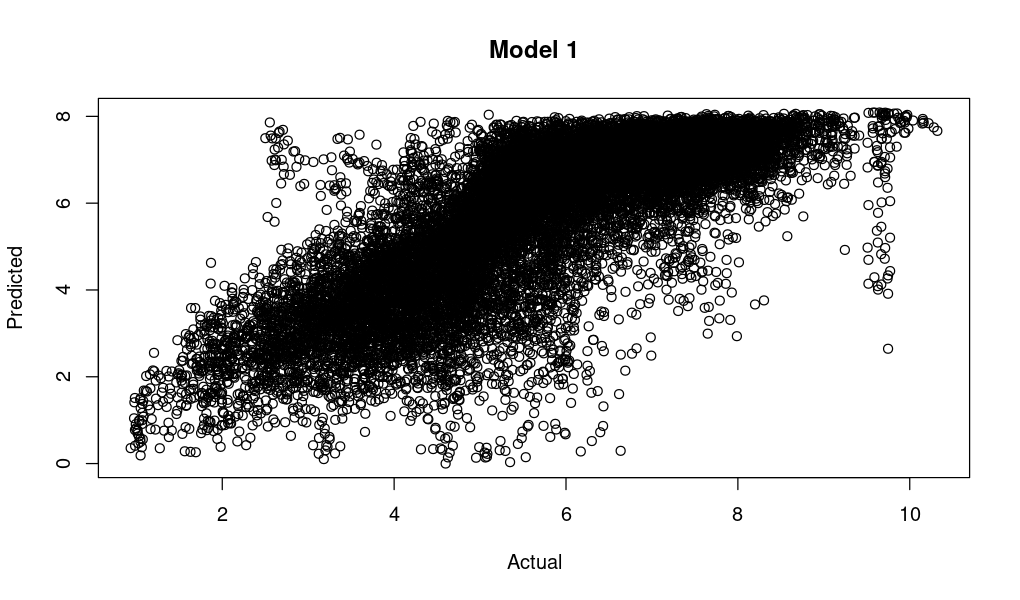

In [8]:
require('rcompanion')
accuracy(list(fit))

### Mixed model describing temporal relationships

In [9]:
library('nlme')
# Fit a mixed model to this data (see model selection in sensitivity_randomDomain.ipynb)
ndviprcp_best <- lme(ndvi_sum ~ prcp_sum, random=~1+prcp_sum|neonDomainName/stationid,
                           correlation=corAR1(),
                           data=df, na.action=na.omit)
AIC(ndviprcp_best)
BIC(ndviprcp_best)


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse



[1] -2109.079

[1] -2030.775

### Linear models describing spatial pattern of NDVI vs precip by domain

These are essentially the stats for the linear fits in the first two plots below.

In [10]:
lmdomainstats <- data.frame(domain=character(), slope=double(),
                            r2=double(), pval=double(), stringsAsFactors=FALSE)
count <- 1
for (d in unique(df$neonDomainName)){
    subs <- subset(df, neonDomainName==d)
    mdl <- lm(ndvi_sum ~ prcp_sum, data=subs, na.action=na.omit)
    lmdomainstats[count,'domain'] <- d
    lmdomainstats[count,'slope'] <- summary(mdl)$coefficients[2,1]
    lmdomainstats[count,'r2'] <- summary(mdl)$adj.r.squared
    lmdomainstats[count,'pval'] <- summary(mdl)$coefficients[2,4]
    count <- count+1
}
lmdomainstats
min(lmdomainstats$r2)
max(lmdomainstats$r2)
min(lmdomainstats$pval)
max(lmdomainstats$pval)

domain                slope         r2            pval         
1  Southeast              3.796598e-04  0.0137520743  2.875095e-04
2  Ozarks Complex         6.961275e-04  0.0695728738  7.697180e-27
3  Desert Southwest       1.317502e-03  0.0207426744  2.155814e-04
4  S Rockies/Col. Plat.   5.445283e-03  0.4143612672 3.102271e-119
5  Pacific Southwest      2.315788e-03  0.4043353103  8.430317e-67
6  Great Basin            4.241778e-03  0.2387103085  2.512300e-90
7  Pacific Northwest      1.141292e-03  0.1419697078  1.498863e-20
8  Central Plains         2.739492e-03  0.4090513009 1.982818e-115
9  Northeast              3.090461e-04  0.0075353744  7.725523e-05
10 Mid Atlantic          -6.125984e-05 -0.0003350752  4.741180e-01
11 Atlantic Neotropical  -2.389448e-03  0.3551964578  4.703366e-06
12 Appalachians/C. Plat.  6.761978e-04  0.0682933080  1.129061e-16
13 Northern Rockies       4.488610e-03  0.4381810958  3.814983e-82
14 Prairie Peninsula      1.221940e-03  0.1952081269 1.104349e-111
15 Great Lakes            3.135456e-04  0.0045872753  1.630865e-02
16 Southern Plains        2.007113e-03  0.3955642927 4.708796e-100
17 Northern Plains        3.160956e-03  0.5275746551 1.032087e-262

[1] -0.0003350752

[1] 0.5275747

[1] 1.032087e-262

[1] 0.474118

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

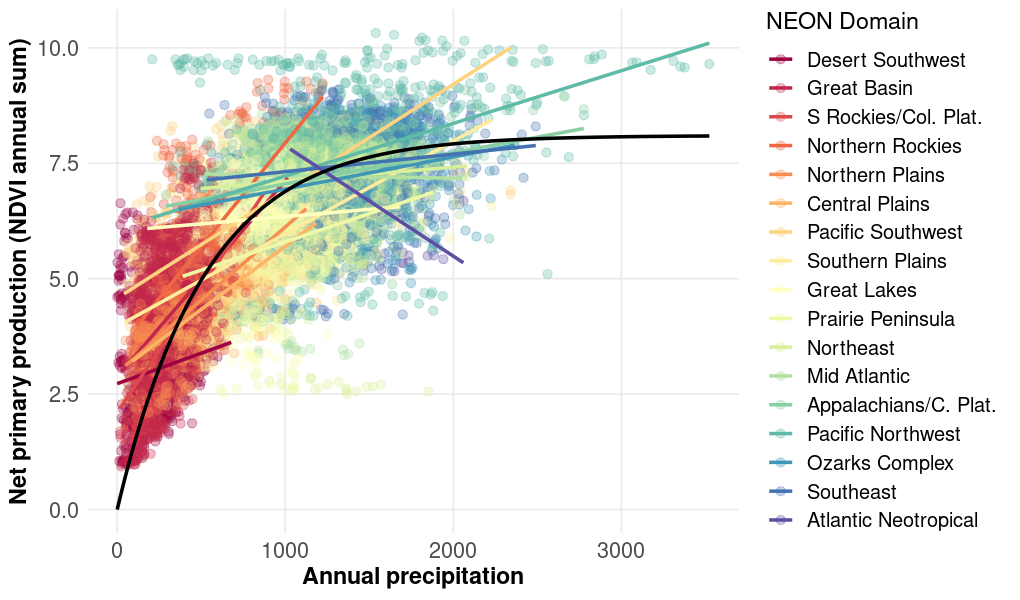

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

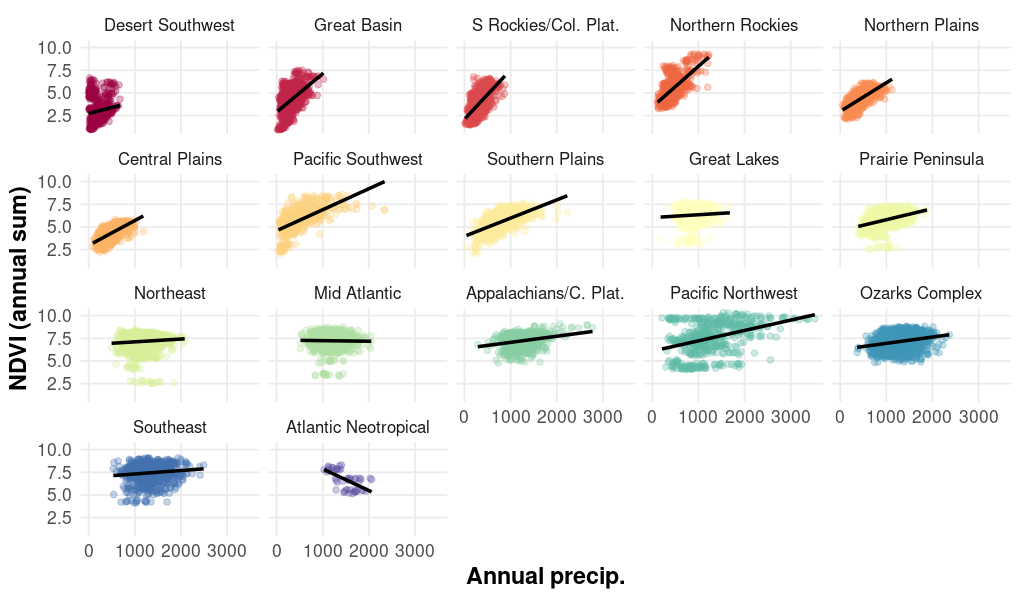

In [11]:
ggplot(df, aes(x=prcp_sum, y=ndvi_sum, col=neonDomainName)) +
    geom_point(alpha=3/10, size=2.25) +
    scale_colour_manual(values=myPal) +
    geom_smooth(method='lm', se=FALSE) +
    #geom_smooth(method="nls", method.args=list(formula = y ~ C*(1-exp(k*x)),na.action=na.exclude,
    #                                           algorithm="port",start=c(C=8,k=-1),lower=c(C=7.5,k=-Inf),
    #                                           upper=c(C=Inf,k=0)), aes(col='black'), data=df.t2) +
    geom_line(aes(x=prcp_sum,y=pred_nlinALL), size=1, col='black') +
    theme_minimal() + theme(panel.grid.minor=element_blank(),axis.text=element_text(size=13),
                            axis.title=element_text(size=14,face="bold"),
                            legend.title=element_text(size=14),legend.text=element_text(size=12)) +
    ylab('Net primary production (NDVI annual sum)') + xlab('Annual precipitation') +
    guides(col=guide_legend(title='NEON Domain'))


ggsave('../figs/NDVIsum_vs_calyrPrcp_spatial.pdf', width=8.5, height=5)
ggsave('../figs/NDVIsum_vs_calyrPrcp_spatial.png', width=8.5, height=5)

ggplot(df, aes(x=prcp_sum, y=ndvi_sum, color=neonDomainName)) +
    geom_point(alpha=3/10) + facet_wrap(~neonDomainName,labeller = label_wrap_gen())  +
    scale_colour_manual(values=myPal, guide=FALSE) +
    #scale_colour_manual(values=rev(terrain.colors(17))) +
    theme_minimal() + theme(panel.grid.minor=element_blank(),axis.text=element_text(size=10.5),
                            axis.title=element_text(size=14,face="bold"),strip.text.x = element_text(size = 10),
                            legend.title=element_text(size=14),legend.text=element_text(size=12)) +
    ylab('NDVI (annual sum)') + xlab('Annual precip.') +
    geom_smooth(method = "lm", se=FALSE, color="black")

ggsave('../figs/NDVIsum_vs_calyrPrcp_spatial_domFacet.pdf', width=8.5, height=5)
ggsave('../figs/NDVIsum_vs_calyrPrcp_spatial_domFacet.png', width=8, height=6)

In [12]:
# Add the temporal relationships to the plot instead of spatial ones (from mixed model)
rows <- rownames(fitted(ndviprcp_best, level=0:2))
#df.t$ypred <- fitted(ndviprcp_best)
df[rows,'fitted'] <- fitted(ndviprcp_best, level=1)
head(df)

stationid   year tavg_mean prcp_sum pet_mean spei3mo_mean spei6mo_mean
1 USH00011084 2000 19.67250  1217.8   83.47748 -0.8398556   -1.2444360  
2 USH00011084 2001 19.43500  1484.2   78.91777  0.1525237    0.2942613  
3 USH00011084 2002 19.75500  1519.1   84.23310 -0.2962908   -0.6979048  
4 USH00011084 2003 19.24417  2004.4   79.40756  0.7594102    1.3003854  
5 USH00011084 2004 19.45917  1913.0   79.52434  0.5110181    0.4005793  
6 USH00011084 2005 19.62250  1753.4   80.32368  0.4701950    1.1018325  
  spei9mo_mean spei12mo_mean spei18mo_mean ⋯ spei12mo_cv5yr_trend
1 -1.2475687   -1.261597657  -1.1473402    ⋯ -5.418599e-05       
2  0.2263476    0.007390897  -0.7079662    ⋯ -5.418599e-05       
3 -1.0084529   -0.981279249  -0.6412289    ⋯ -5.418599e-05       
4  1.3518682    1.110410712   0.5340491    ⋯ -5.418599e-05       
5  0.6190559    0.925218898   1.4362224    ⋯ -5.418599e-05       
6  1.4217346    1.435020050   1.3912327    ⋯ -5.418599e-05       
  spei12mo_cv5yr_trend_sig spi12mo_trend spi12mo_trend_sig spi12mo_cv5yr_trend
1 1.450005e-23             0.000347507   4.515042e-09      -2.761315e-05      
2 1.450005e-23             0.000347507   4.515042e-09      -2.761315e-05      
3 1.450005e-23             0.000347507   4.515042e-09      -2.761315e-05      
4 1.450005e-23             0.000347507   4.515042e-09      -2.761315e-05      
5 1.450005e-23             0.000347507   4.515042e-09      -2.761315e-05      
6 1.450005e-23             0.000347507   4.515042e-09      -2.761315e-05      
  spi12mo_cv5yr_trend_sig neonDomainName domain_map pred_nlinALL fitted  
1 1.117645e-08            Southeast      1341.712   7.299877     7.392410
2 1.117645e-08            Southeast      1341.712   7.617790     7.456502
3 1.117645e-08            Southeast      1341.712   7.648741     7.464898
4 1.117645e-08            Southeast      1341.712   7.920611     7.581654
5 1.117645e-08            Southeast      1341.712   7.886573     7.559664
6 1.117645e-08            Southeast      1341.712   7.810929     7.521267

Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

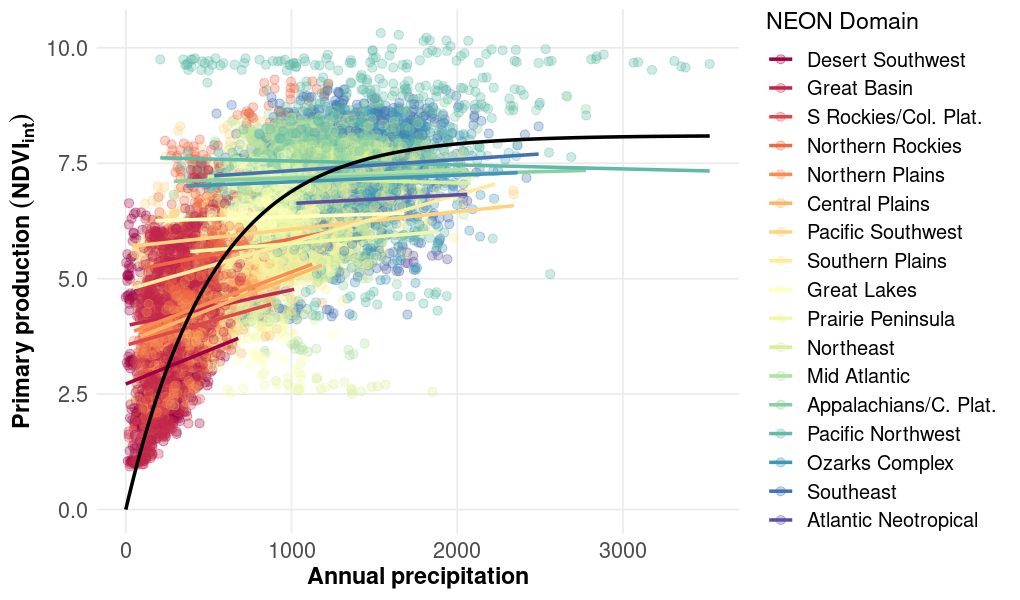

In [13]:
ggplot(df, aes(x=prcp_sum, y=ndvi_sum, col=neonDomainName)) +
    geom_point(alpha=3/10, size=2.25) +
    scale_colour_manual(values=myPal) +
    geom_line(data=df[!is.na(df$fitted),], aes(x=prcp_sum, y=fitted, col=neonDomainName), size=1) +
    #geom_smooth(method='lm', se=FALSE) +
    #geom_smooth(method='glm', formula=(y ~ c(1-exp(-x/1000))), se=TRUE, col='black') +
    #geom_smooth(method="glm", formula=(y ~ exp(-x/1000)), method.args=list(family=gaussian(link="log")), col='black') +
    #geom_smooth(method="nls", method.args=list(formula = y ~ C*(1-exp(k*x)),na.action=na.exclude,
    #                                           algorithm="port",start=c(C=8,k=-1),lower=c(C=7.5,k=-Inf),
    #                                           upper=c(C=Inf,k=0)), aes(col='black'), data=df.t2) +
    geom_line(aes(x=prcp_sum,y=pred_nlinALL), size=1, col='black') +
    theme_minimal() + theme(panel.grid.minor=element_blank(),axis.text=element_text(size=13),
                            axis.title=element_text(size=14,face="bold"),
                            legend.title=element_text(size=14),legend.text=element_text(size=12)) +
    ylab(expression(bold('Primary production '* (NDVI[int])))) + xlab('Annual precipitation') +
    guides(col=guide_legend(title='NEON Domain'))
    #guides(shape = guide_legend(override.aes = list(size = 10)))
    #geom_smooth(method = "loess", se=FALSE, color="black")

ggsave('../figs/NDVIsum_vs_calyrPrcp_sp+tempdomain.pdf', width=8.5, height=5)
ggsave('../figs/NDVIsum_vs_calyrPrcp_sp+tempdomain.png', width=8.5, height=5, dpi=600)

In [14]:
sqrt(mean(residuals(fit)^2))

[1] 1.095007

### Annual mean NDVI vs summed precip

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

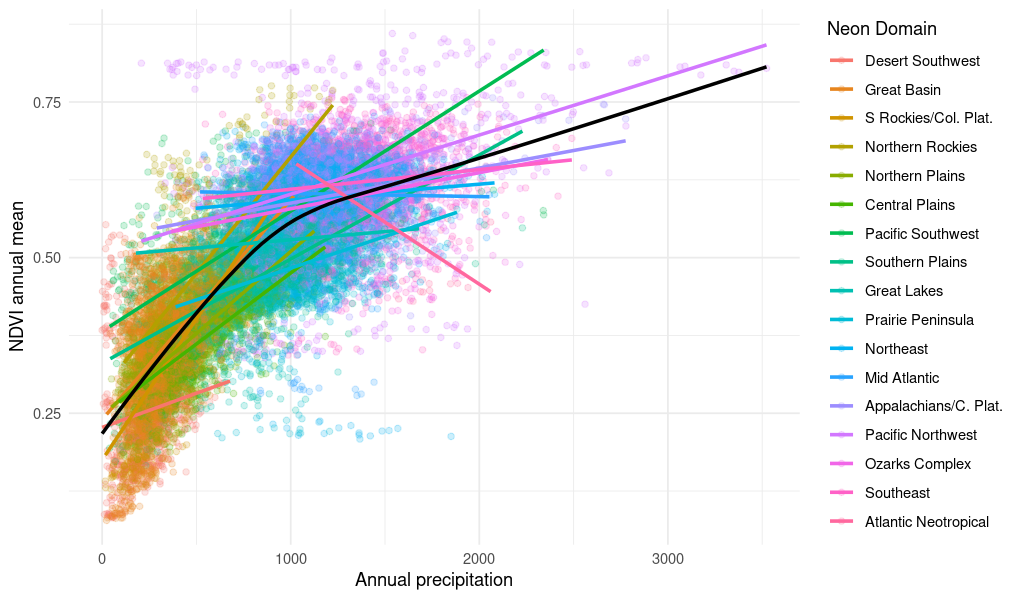

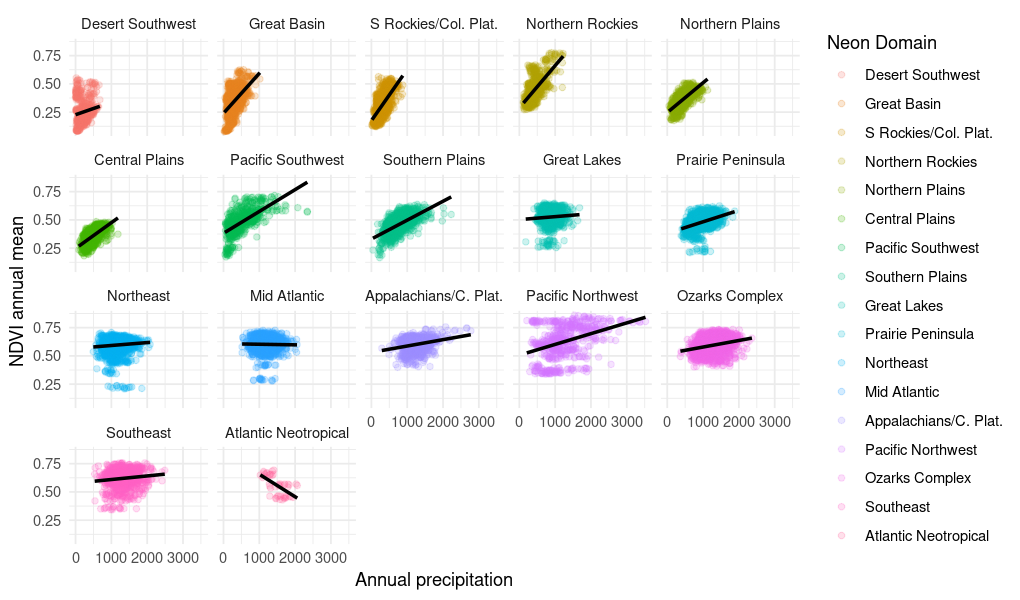

In [15]:
ggplot(df, aes(x=prcp_sum, y=ndvi_mean, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('NDVI annual mean') + xlab('Annual precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=prcp_sum, y=ndvi_mean, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName) +
    theme_minimal() + ylab('NDVI annual mean') + xlab('Annual precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

### Annual summed zNDVI vs precip

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

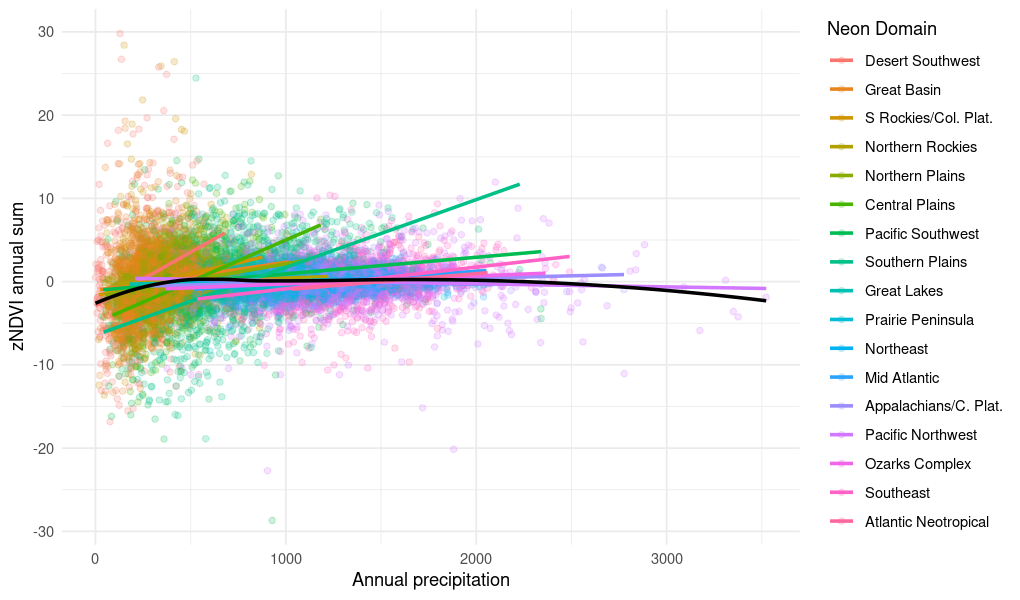

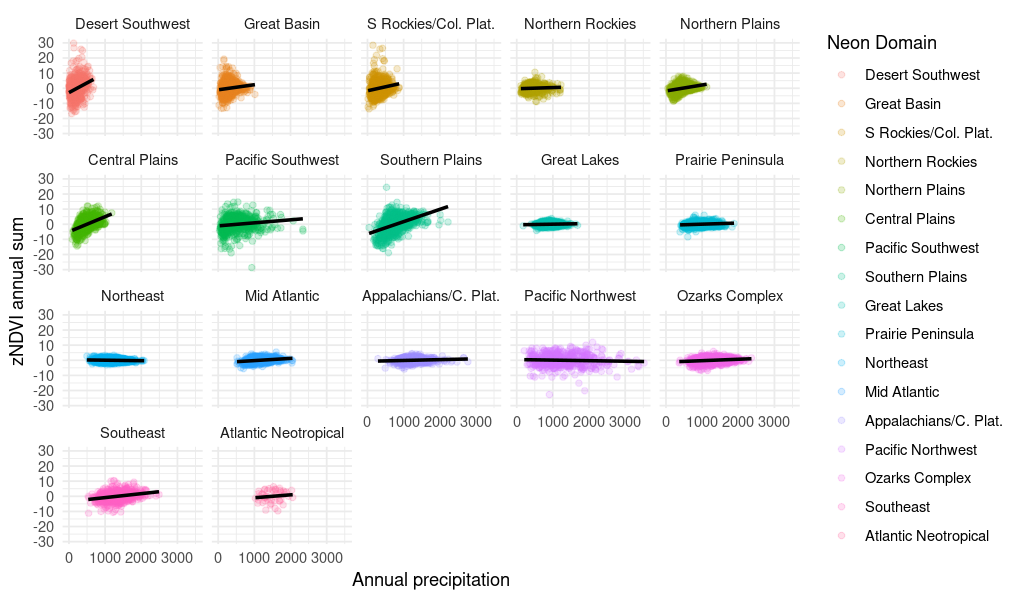

In [16]:
ggplot(df, aes(x=prcp_sum, y=zndvi_sum, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('zNDVI annual sum') + xlab('Annual precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=prcp_sum, y=zndvi_sum, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName)  +
    theme_minimal() + ylab('zNDVI annual sum') + xlab('Annual precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

### Annual mean zNDVI vs summed precip

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

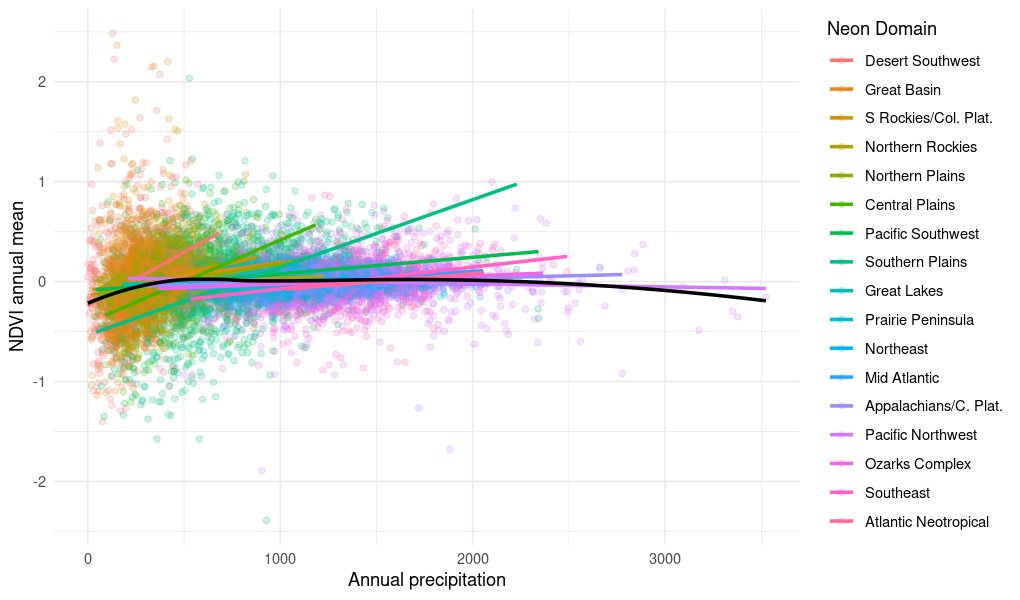

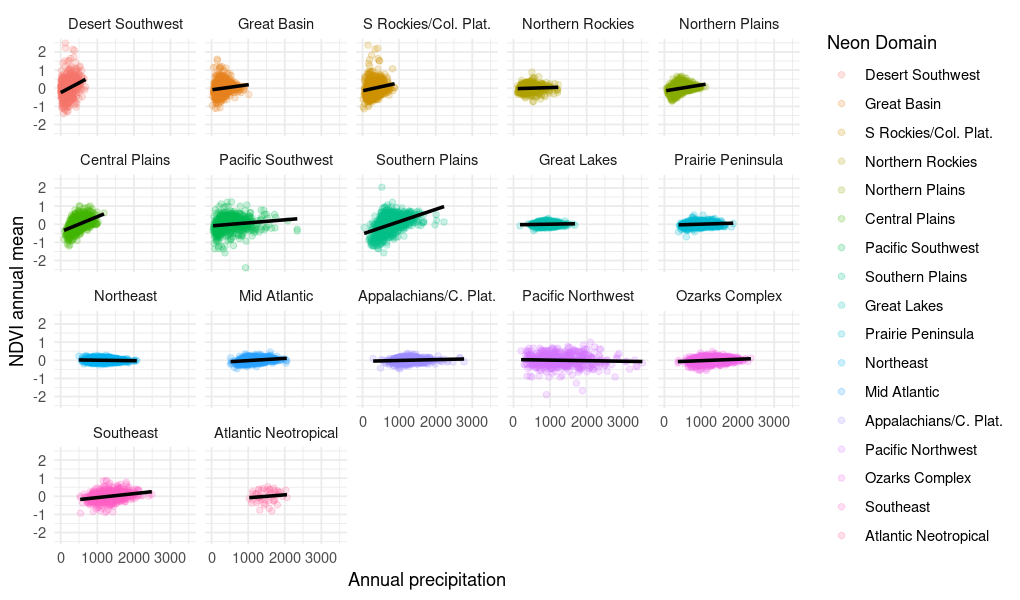

In [17]:
ggplot(df, aes(x=prcp_sum, y=zndvi_mean, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('NDVI annual mean') + xlab('Annual precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=prcp_sum, y=zndvi_mean, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName)  +
    theme_minimal() + ylab('NDVI annual mean') + xlab('Annual precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

## Examine SPEI sensitivity
### Annual summed NDVI vs mean 12 month SPEI

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

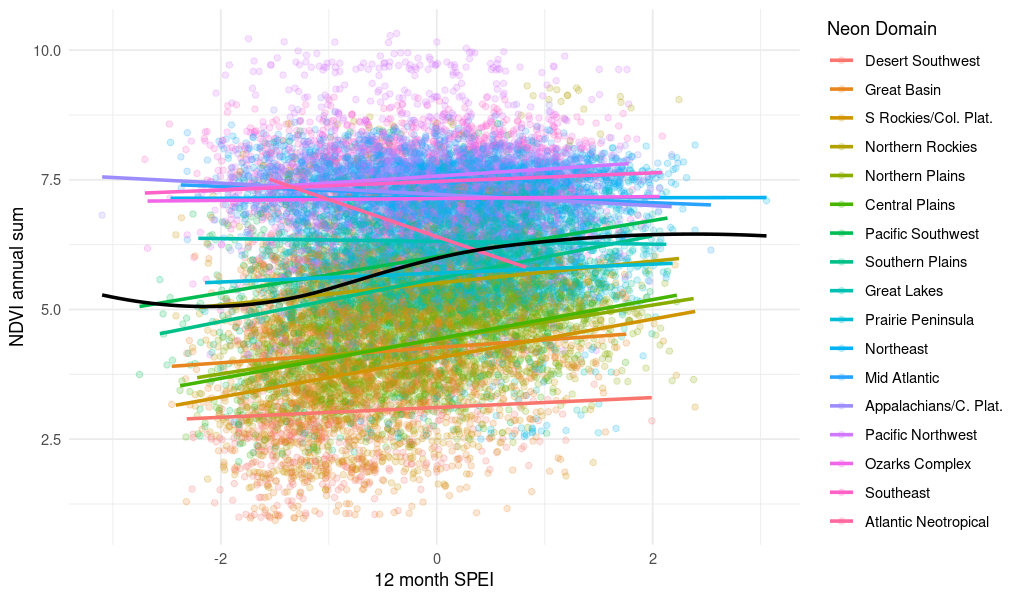

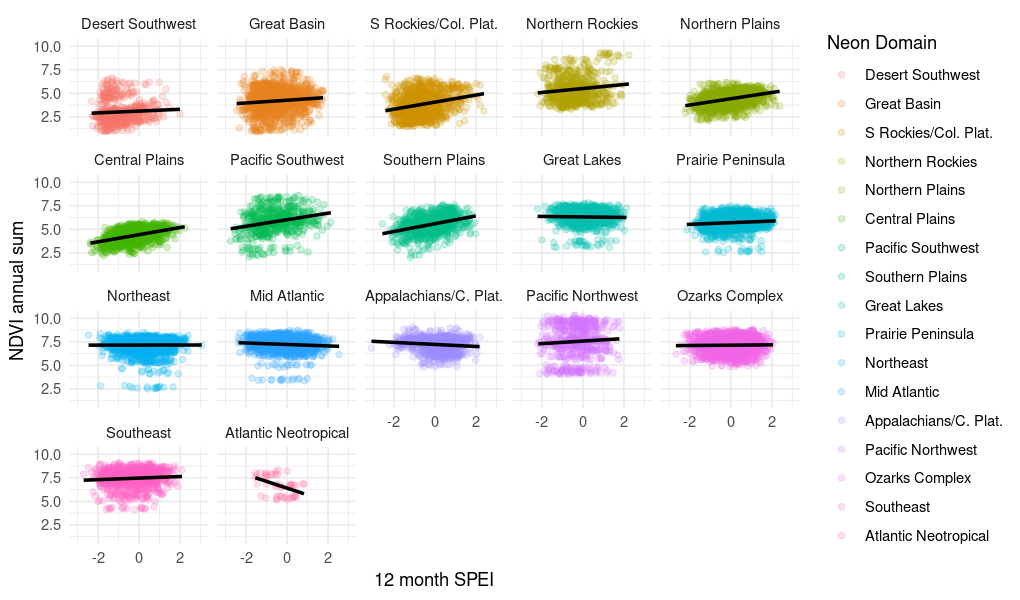

In [18]:
ggplot(df, aes(x=spei12mo_mean, y=ndvi_sum, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('NDVI annual sum') + xlab('12 month SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=spei12mo_mean, y=ndvi_sum, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName)  +
    theme_minimal() + ylab('NDVI annual sum') + xlab('12 month SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

### Annual mean NDVI vs mean 12 month SPEI

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

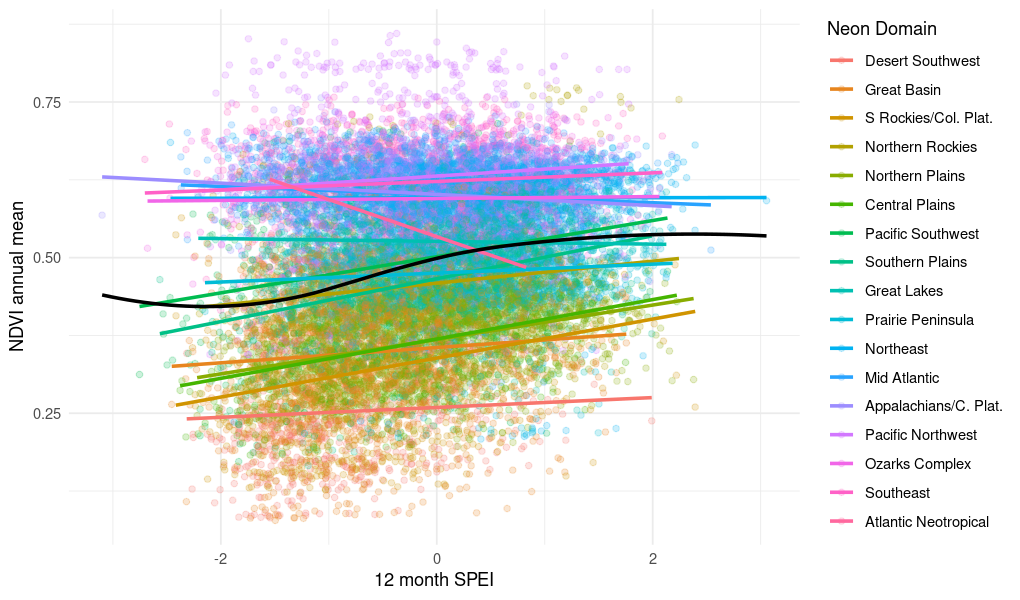

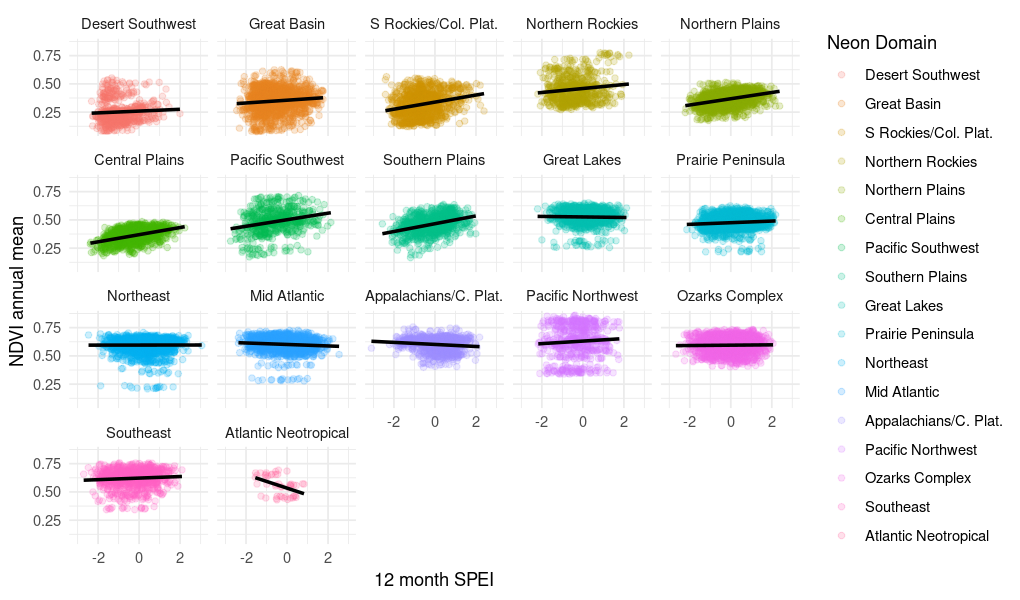

In [19]:
ggplot(df, aes(x=spei12mo_mean, y=ndvi_mean, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('NDVI annual mean') + xlab('12 month SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=spei12mo_mean, y=ndvi_mean, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName)  +
    theme_minimal() + ylab('NDVI annual mean') + xlab('12 month SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

### Annual summed zNDVI vs mean 12 month SPEI

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

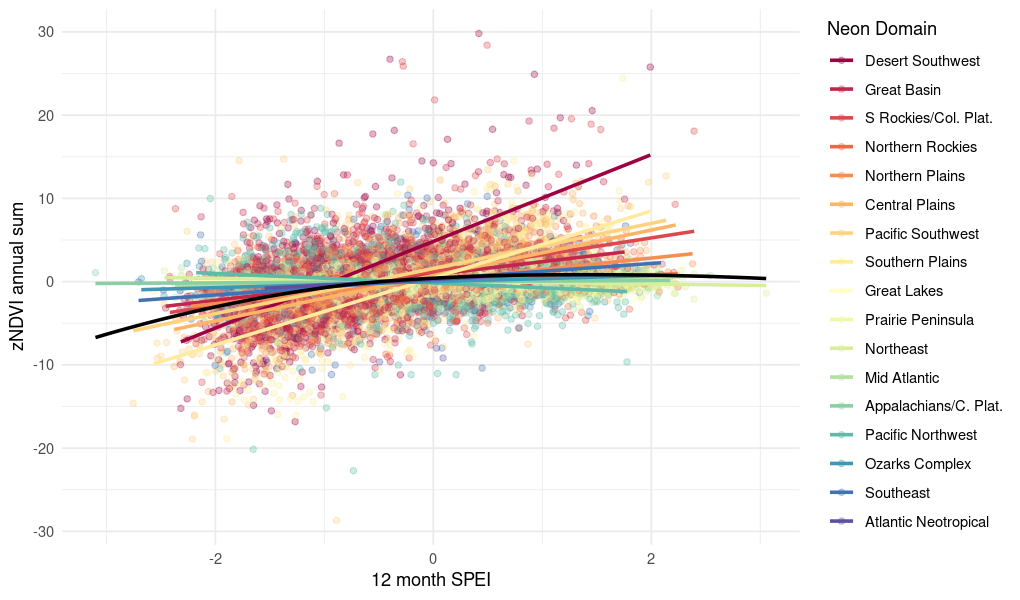

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

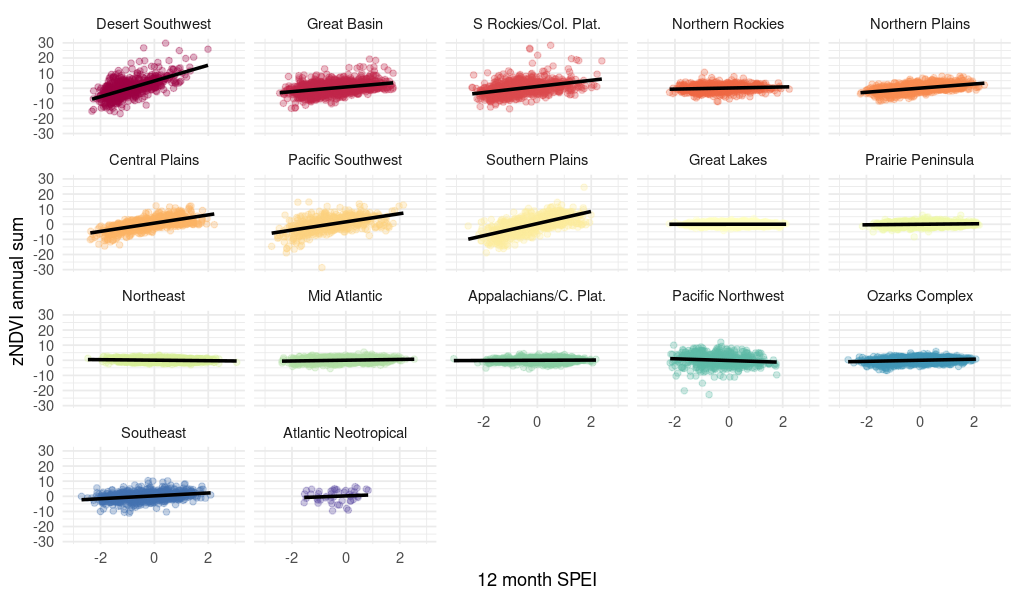

In [20]:
ggplot(df, aes(x=spei12mo_mean, y=zndvi_sum, col=neonDomainName)) +
    geom_point(alpha=3/10) +
    scale_colour_manual(values=myPal) +
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('zNDVI annual sum') + xlab('12 month SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggsave('../figs/zNDVIsum_vs_12moSPEI.pdf', width=8.5, height=5)
ggsave('../figs/zNDVIsum_vs_12moSPEI.png', width=8.5, height=5)

ggplot(df, aes(x=spei12mo_mean, y=zndvi_sum, color=neonDomainName)) +
    geom_point(alpha=3/10) + facet_wrap(~neonDomainName,labeller = label_wrap_gen()) +
    scale_colour_manual(values=myPal, guide=FALSE) +
    theme_minimal() + ylab('zNDVI annual sum') + xlab('12 month SPEI') +
    #guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

ggsave('../figs/zNDVIsum_vs_12moSPEI_domFacet.pdf', width=8.5, height=5)
ggsave('../figs/zNDVIsum_vs_12moSPEI_domFacet.png', width=7, height=5)

### Annual mean zNDVI vs mean 12 month SPEI

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

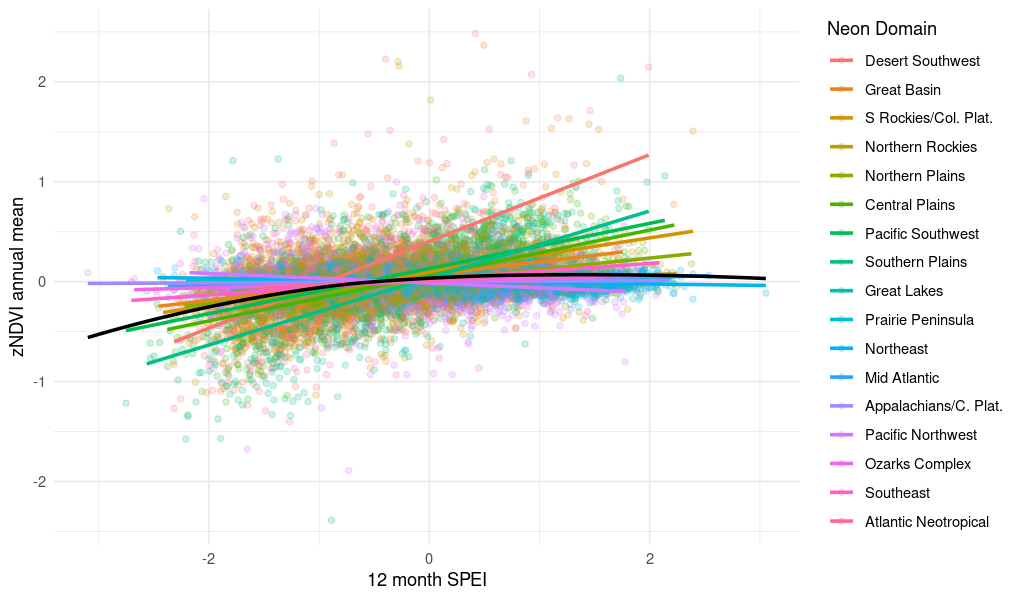

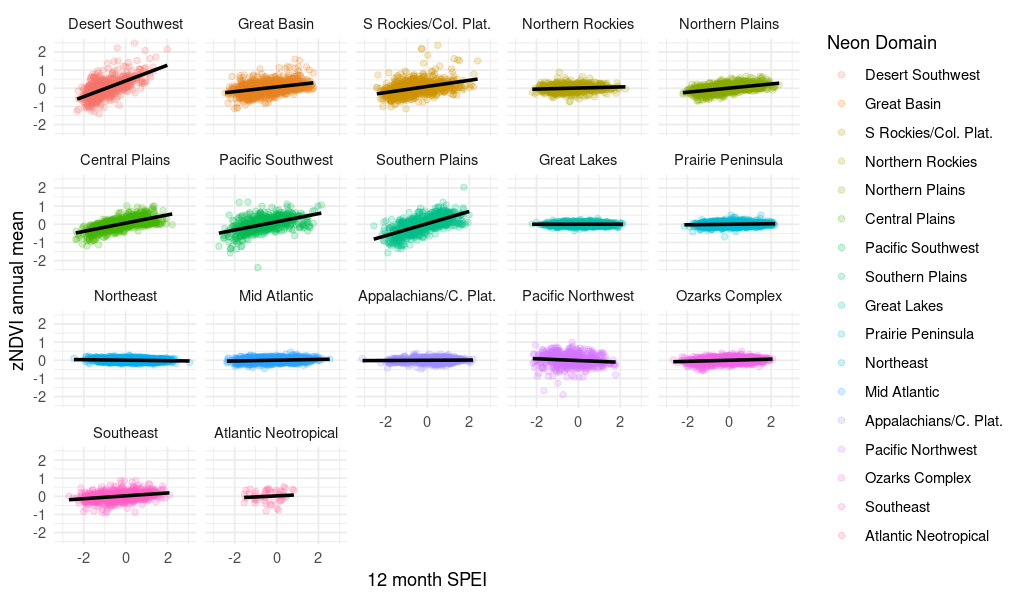

In [21]:
ggplot(df, aes(x=spei12mo_mean, y=zndvi_mean, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('zNDVI annual mean') + xlab('12 month SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=spei12mo_mean, y=zndvi_mean, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName)  +
    theme_minimal() + ylab('zNDVI annual mean') + xlab('12 month SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

## Examine growing season sensitivity
### 

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

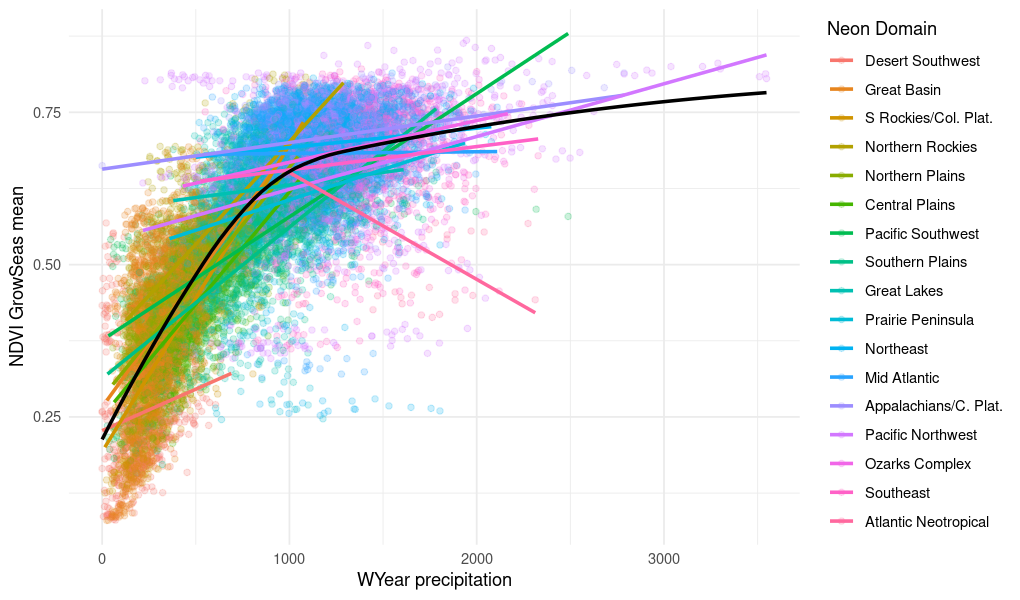

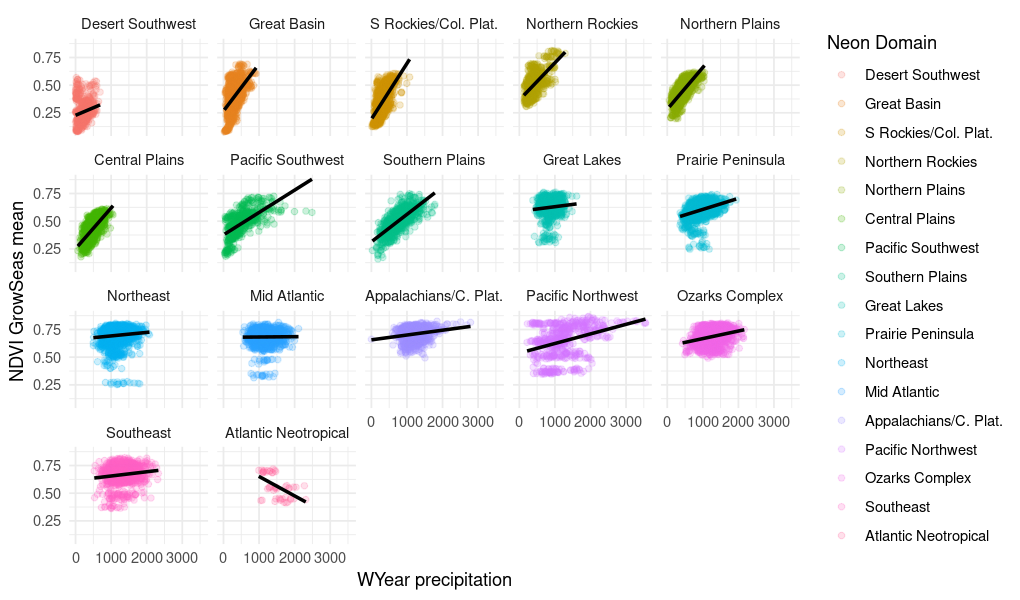

In [22]:
ggplot(df, aes(x=prcp_wysum, y=ndvi_gsmean, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('NDVI GrowSeas mean') + xlab('WYear precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=prcp_wysum, y=ndvi_gsmean, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName)  +
    theme_minimal() + ylab('NDVI GrowSeas mean') + xlab('WYear precipitation') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")

Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”Warning message:
“Removed 736 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 736 rows containing missing values (geom_point).”

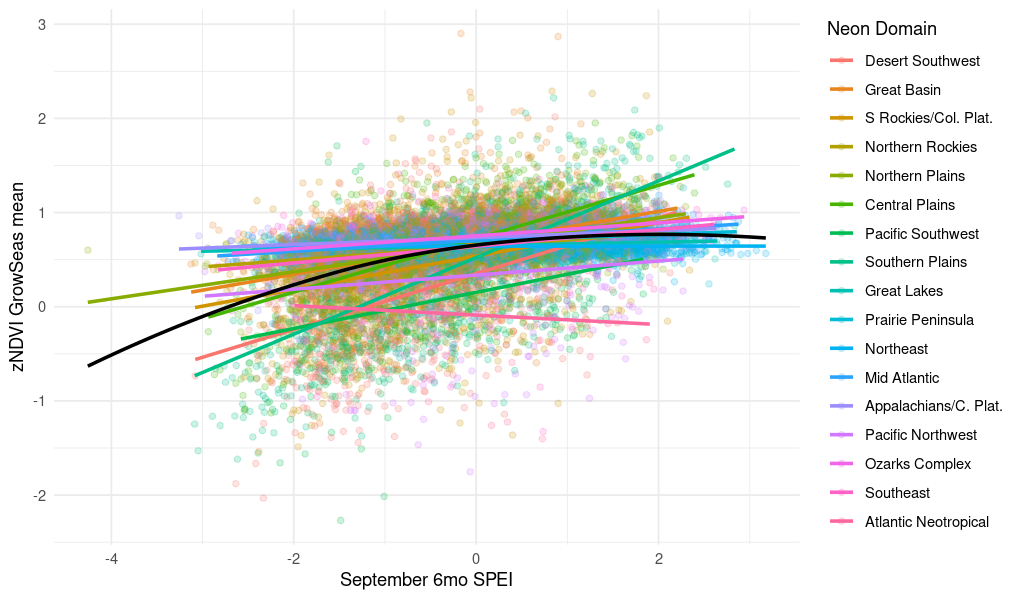

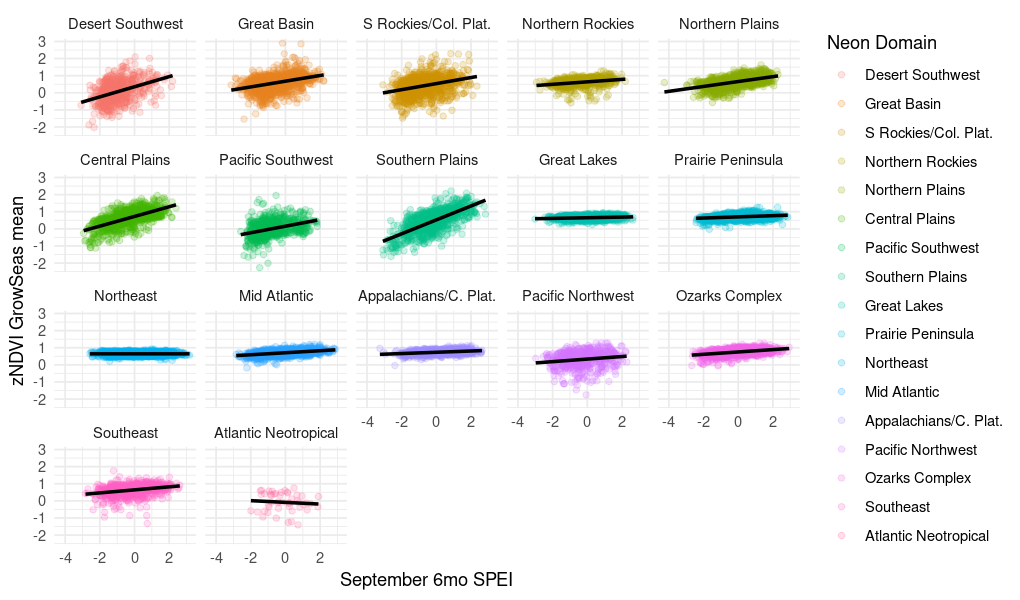

In [23]:
ggplot(df, aes(x=spei6mo_september, y=zndvi_gsmean, col=neonDomainName)) +
    geom_point(alpha=2/10) + 
    geom_smooth(method='lm', se=FALSE) +
    theme_minimal() + ylab('zNDVI GrowSeas mean') + xlab('September 6mo SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "loess", se=FALSE, color="black")

ggplot(df, aes(x=spei6mo_september, y=zndvi_gsmean, color=neonDomainName)) +
    geom_point(alpha=2/10) + facet_wrap(~neonDomainName)  +
    theme_minimal() + ylab('zNDVI GrowSeas mean') + xlab('September 6mo SPEI') +
    guides(col=guide_legend(title='Neon Domain')) +
    geom_smooth(method = "lm", se=FALSE, color="black")